<h1>制御対象の振舞い</h1>

Pythonによる制御工学入門 P94~  


<h2>時間応答</h2>

まずは代表的なシステムである１次遅れ系（First-Order Lag System）と２次遅れ系（Second-Order Lag System）を見ていきます。  

加えて、ステップ上の入力を加えたときの出力の振舞いである **ステップ応答 (Step Response)**を見ていきます。  

ステップ応答は以下の式の通りに定義されます。  

```math
u(t) = \left\{
    \begin{array}{ll}
        1 & (t \geq 0) \\
        0 & (t \lt 0)
    \end{array}
\right.
```

Pythonの```control```モジュールでは、ステップ応答は```y, t = step(sys, Td)```で計算できます。

<h3>１次遅れ系 First-Order Lag System</h3>

このノートブックで使う例として、台車の伝達関数モデルを使います。  

```math
P(s) = \frac{1}{Ms + \mu} = \frac{\frac{1}{\mu}}{1 + \frac{M}{\mu}s}
```

１次遅れ系には$K$をゲイン、$T$を時定数のパラメータを持ち、上記の台車系の伝達関数モデルに対して$K=\frac{1}{\mu}$、$T=\frac{M}{\mu}$と置くと、台車系の伝達関数モデルを適用した１次遅れ系は以下のように定義できます。  

```math
P(s) = \frac{K}{1+Ts}
```

上記の式を早速計算させてみます。

In [18]:
def steady_value(t: float, ts: list, y: list) -> float:
    for i, ti in enumerate(ts):
        if t == ti:
            return y[i]

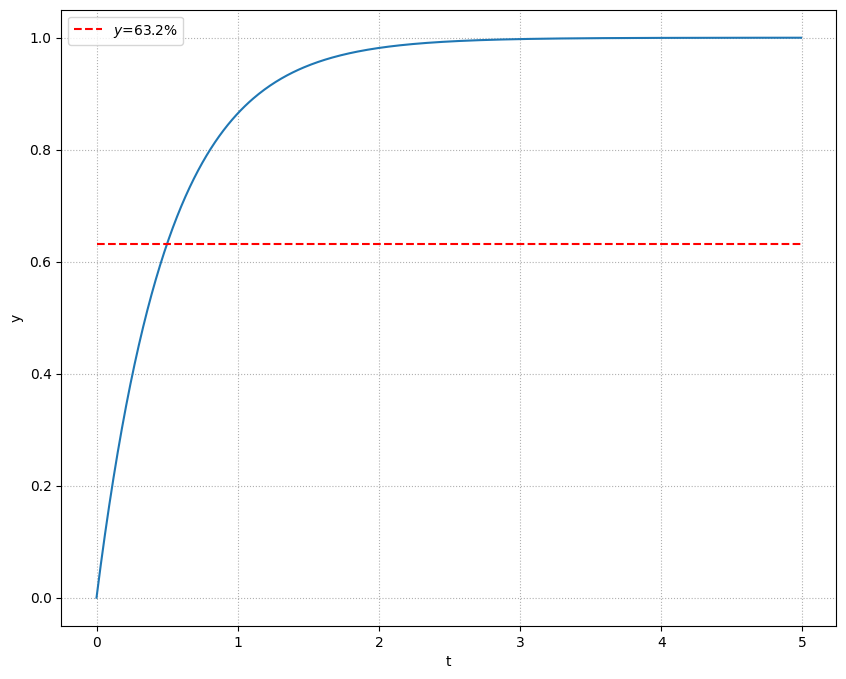

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from control.matlab import tf, step
from control.matlab import TransferFunction

from plot import plot_set

# Define the transfer function for the system
T, K = 0.5, 1
P = tf([0, K], [T, 1])
y, t = step(P, np.arange(0, 5, 0.01))
v = steady_value(T, t, y)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(t, y)
ax.plot(t, np.full(len(t), v), 'r--', label=f'$y$={v*100:.1f}%')
ax.legend()
plot_set(ax, 't', 'y')

上記の１次遅れ系で$T=0.5$、$K=1$だった時の場合の定常値（時間が十分経過したときの値）$y$は63.2%ととなります。言い換えると、出力の定常値の63.2%に到達する時間の時定数が$T=0.5$と表現できます。  

$T$は速応性（応答の速度）を決定するパラメータになりますので、中々良い数字のように思えます。  

もし、時定数$T$を徐々に下げていくとどうなるでしょうか？

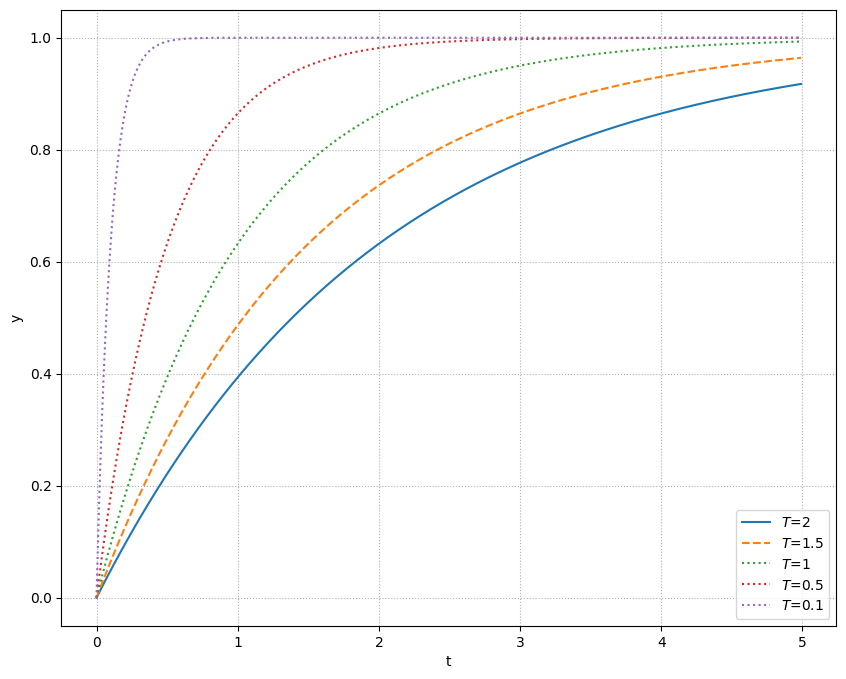

In [39]:
from plot import linestype_generator

# define the calculation of y and t, steady values.
def first_order_lag_system(K: float, T: list[float]) -> list:
    res = []
    for ts in T:
        P = tf([0, K], [ts, 1])
        y, t = step(P, np.arange(0, 5, 0.01))
        res.append((y, t))
    return res

# let's calculation!
LS = linestype_generator()
fig, ax = plt.subplots(figsize=(10, 8))

K = 1
T = [2, 1.5, 1, 0.5, 0.1]

ys = first_order_lag_system(K, T)

for ts, (y, t) in zip(T, ys):
    ax.plot(t, y, ls=next(LS), label=f'$T$={ts}')
    ax.legend()

plot_set(ax, 't', 'y')

パラメータ$T$を大きくすれば応答は遅くなり、小さくすれば応答は早くなりそうな予感がします。そして、その予測は上記の図を見る限りでは当たっているように思われます。  

反対に、$T=-1$の時はどうなるでしょうか？

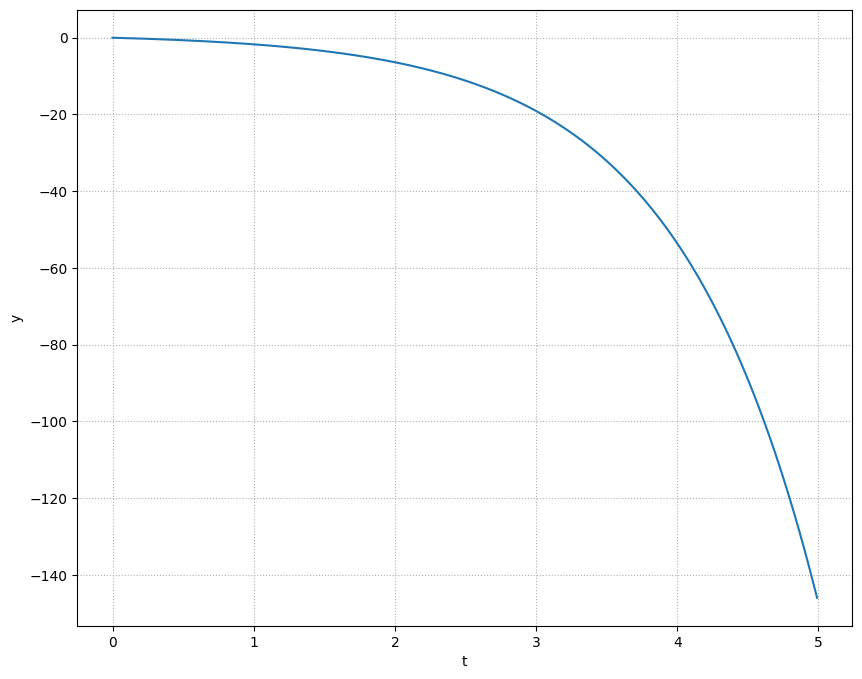

In [41]:
K = 1
T = -1

P = tf([0, K], [T, 1])
y, t = step(P, np.arange(0, 5, 0.01))

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(t, y)
plot_set(ax, 't', 'y')

$T$が負数のとき、一定値には収束せず発散し、出力値$y$は-140以上まで下がることがわかります。  

パラメータ$K$を変化させたとき、どうなるでしょうか？合わせて、$K$を変化させると定常値も変わるため、定常値がどうなるかも合わせて確認してみます。

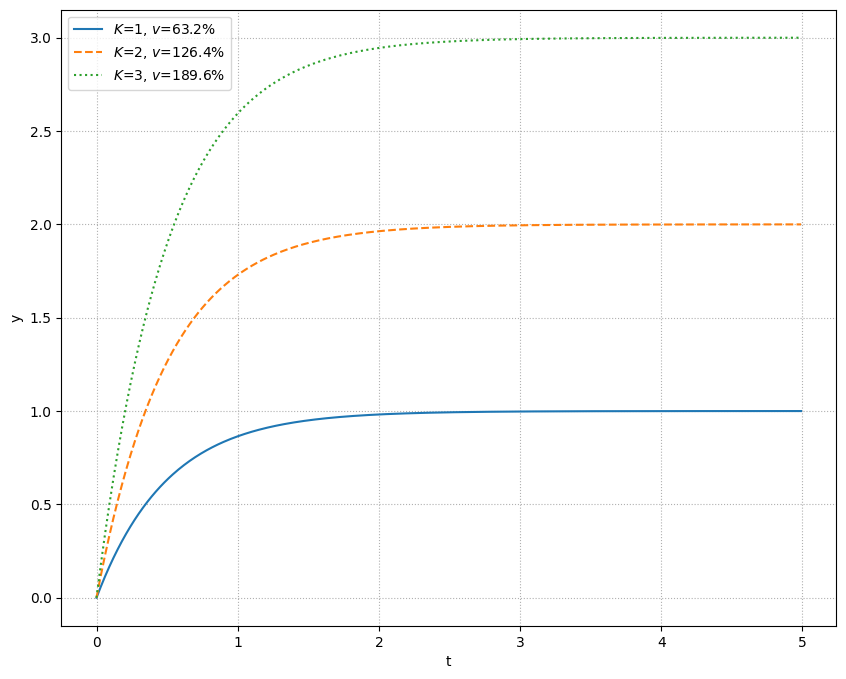

In [44]:
LS = linestype_generator()
fig, ax = plt.subplots(figsize=(10, 8))

def first_order_lag_system(K: list[float], T: float) -> list:
    res = []
    for Ki in K:
        P = tf([0, Ki], [T, 1])
        y, t = step(P, np.arange(0, 5, 0.01))
        v = steady_value(T, t, y)
        res.append((y, t, v))
    return res

K = [1, 2, 3]
T = 0.5

ys = first_order_lag_system(K, T)

for Ki, (y, t, v) in zip(K, ys):
    ax.plot(t, y, ls=next(LS), label=f'$K$={Ki}, $v$={v*100:.1f}%')
    ax.legend()

plot_set(ax, 't', 'y')

パラメータ$K$を大きくすると、定常値$y$も大きくなります。このことから、定常値が$y(\infty)=K$になることが分かります。

台車のモデルと上の１次遅れ系とを紐づけてみると、車輪を動かすモータに一定の電圧を印加すると台車は動き出し、一定の速度で走り続けるようになります。  

台車の質量が小さければ、動き始めから等速になるまでの間が短くなり速度も早くなります。反対に台車の質量が大きければ、動き始めから等速までの間が長くなり、速度も小さいものになります。これは$T=\frac{M}{\mu}$と$K=\frac{1}{\mu}$、粘性摩擦との関連から、直観的に理解可能です。  